In [29]:
import networkx as nx
import networkx.algorithms.community as nx_comm
import pandas as pd
import math
import matplotlib.pyplot as plt

In [2]:
def strength_centrality(G, out=True): 
    strengths = dict()
    sum_of_weights = 0
    for node in G.nodes:
        strengths[node] = 0
    for u, v, d in G.edges(data=True):
        if not out: #se non è out scambio i nodi
            k = v
            v = u
            u = k
        strengths[u] += d["weight"]
        sum_of_weights += d["weight"]
    
    for key in strengths.keys():
        strengths[key] = strengths[key] / sum_of_weights
        
    return dict(sorted(strengths.items(), key=lambda item: item[1], reverse=True)) 
        

In [3]:
Threshold = 1
path_dataset = "DatasetWithCountries.xlsx"

df = pd.read_excel(path_dataset)
df = df[df["Value (thousands USD)"] > Threshold]
df['ContinentExporter'] = df['ContinentExporter'].fillna("NA")
df['ContinentImporter'] = df['ContinentImporter'].fillna("NA")

# Coal

In [4]:
df_coal = df[df["Product"] == "Coal"]
df_coal.head()

,Exporter,Importer,Product,Value (thousands USD),ContinentExporter,ContinentImporter
5,ALB,SRB,Coal,33.708,EU,EU
87,AZE,GEO,Coal,43.500,AS,AS
118,ARG,BRA,Coal,229.782,SA,SA
123,ARG,CHL,Coal,1022.578,SA,SA
130,ARG,PRY,Coal,56.766,SA,SA


### Find Nodes and Edges

In [5]:
coal_nodes = list(set(df_coal["Exporter"].unique().tolist() + df_coal["Importer"].unique().tolist()))

continent_mapping = {}
for (index, row) in df_coal.iterrows():
    continent_mapping[row["Exporter"]] = row["ContinentExporter"]
    continent_mapping[row["Importer"]] = row["ContinentImporter"]

coal_edges = [(row["Exporter"], row["Importer"], row["Value (thousands USD)"]) for (index, row) in df_coal.iterrows()]


## Create Graph

In [6]:
G_coal = nx.DiGraph()

G_coal.add_nodes_from(coal_nodes)
for node in G_coal.nodes():
    G_coal.nodes[node]["Continent"] = continent_mapping[node]

G_coal.add_weighted_edges_from(coal_edges)

inverse_weights = {}
for u, v, d in G_coal.edges(data=True):
    inverse_weights[(u,v)] = math.log(d["weight"]+1)
    
nx.set_edge_attributes(G_coal, inverse_weights, name="inverse_weights")


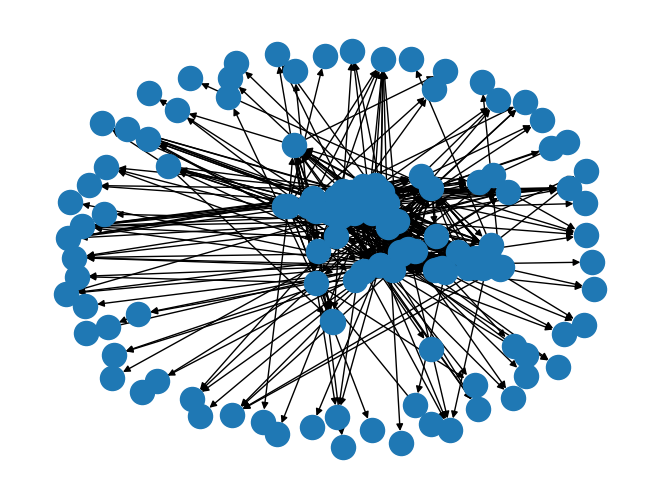

In [7]:
nx.draw(G_coal)

## Degree centrality

In [8]:
sorted(nx.out_degree_centrality(G_coal).items(), key=lambda item: item[1], reverse=True)

[('CHN', 0.43478260869565216),
 ('POL', 0.37681159420289856),
 ('DEU', 0.32608695652173914),
 ('RUS', 0.2898550724637681),
 ('USA', 0.2463768115942029),
 ('ITA', 0.2391304347826087),
 ('COL', 0.2246376811594203),
 ('CZE', 0.2246376811594203),
 ('ESP', 0.21014492753623187),
 ('GBR', 0.18115942028985507),
 ('BEL', 0.13043478260869565),
 ('NLD', 0.12318840579710146),
 ('HUN', 0.10144927536231885),
 ('LBN', 0.10144927536231885),
 ('ZAF', 0.10144927536231885),
 ('JPN', 0.10144927536231885),
 ('IND', 0.09420289855072464),
 ('FIN', 0.07246376811594203),
 ('AUT', 0.06521739130434782),
 ('FRA', 0.06521739130434782),
 ('DNK', 0.057971014492753624),
 ('AUS', 0.057971014492753624),
 ('TUR', 0.057971014492753624),
 ('BIH', 0.050724637681159424),
 ('IDN', 0.050724637681159424),
 ('ARE', 0.050724637681159424),
 ('UKR', 0.043478260869565216),
 ('SWE', 0.043478260869565216),
 ('KAZ', 0.043478260869565216),
 ('ROU', 0.043478260869565216),
 ('BGR', 0.036231884057971016),
 ('CAN', 0.036231884057971016),
 

In [9]:
sorted(nx.in_degree_centrality(G_coal).items(), key=lambda item: item[1], reverse=True)

[('IND', 0.18115942028985507),
 ('NLD', 0.13768115942028986),
 ('FRA', 0.13768115942028986),
 ('DEU', 0.13768115942028986),
 ('GBR', 0.13043478260869565),
 ('ESP', 0.12318840579710146),
 ('BEL', 0.11594202898550725),
 ('CHN', 0.11594202898550725),
 ('MYS', 0.10869565217391304),
 ('USA', 0.09420289855072464),
 ('AUT', 0.08695652173913043),
 ('TUR', 0.08695652173913043),
 ('BGR', 0.07971014492753624),
 ('ITA', 0.07971014492753624),
 ('POL', 0.07971014492753624),
 ('CHE', 0.07971014492753624),
 ('IDN', 0.07971014492753624),
 ('SWE', 0.07971014492753624),
 ('JPN', 0.07971014492753624),
 ('SVK', 0.07971014492753624),
 ('NOR', 0.07246376811594203),
 ('ROU', 0.07246376811594203),
 ('KOR', 0.06521739130434782),
 ('MAR', 0.06521739130434782),
 ('SRB', 0.06521739130434782),
 ('HUN', 0.057971014492753624),
 ('RUS', 0.057971014492753624),
 ('PAK', 0.057971014492753624),
 ('CAN', 0.057971014492753624),
 ('AUS', 0.057971014492753624),
 ('MEX', 0.057971014492753624),
 ('VNM', 0.057971014492753624),
 

### out_strength_centrality

In [10]:
out_strengths_centrality = strength_centrality(G_coal, out=True)
print(out_strengths_centrality)

{'POL': 0.25094190709138825, 'CHN': 0.1456735995231024, 'JPN': 0.11677536622331766, 'COL': 0.11658506686042963, 'RUS': 0.10397322368306136, 'DEU': 0.045706670047727334, 'USA': 0.03313399442750501, 'CZE': 0.028645574794181516, 'AUS': 0.023161629300708808, 'BIH': 0.016555099515807192, 'ITA': 0.015985029627646228, 'NLD': 0.01433612508139034, 'IDN': 0.01200972313054296, 'HUN': 0.0088486576298807, 'CHE': 0.0068832863980703525, 'KOR': 0.0063698099719951065, 'MOZ': 0.006196619285115749, 'ESP': 0.005858969413654278, 'CHL': 0.004667710793851064, 'IND': 0.004306362666657528, 'ZWE': 0.0039010813793359583, 'CAN': 0.0034357486553541166, 'NZL': 0.0033903833051760553, 'BEL': 0.0032112441277748114, 'ZAF': 0.0030266057778914014, 'SGP': 0.002734596367573676, 'FIN': 0.0019956850549465673, 'UKR': 0.0015599885029209748, 'GBR': 0.0014130330070956873, 'HKG': 0.0013852197365283553, 'ROU': 0.001064336220590599, 'EGY': 0.0008646674922607559, 'SWE': 0.0008099619903786367, 'FRA': 0.0006390107246824989, 'IRN': 0.0

### in_strength_centrality

In [11]:
in_strengths_centrality = strength_centrality(G_coal, out=False)
print(in_strengths_centrality)

{'IND': 0.11271719056813764, 'CHN': 0.1074477353838679, 'DEU': 0.0654300917208024, 'BRA': 0.052438873030909404, 'MYS': 0.047139637756699417, 'GBR': 0.045170416584397924, 'ESP': 0.04293543786079359, 'KAZ': 0.04199981934009526, 'VNM': 0.03782535741616425, 'MEX': 0.03580367034238925, 'IDN': 0.03178950598960504, 'ROU': 0.029769867820429202, 'CAN': 0.028094993515914168, 'AUT': 0.027725245632610675, 'FRA': 0.02681497692956545, 'ITA': 0.022890967067525185, 'SRB': 0.020304113891343043, 'JPN': 0.0200430099271568, 'BEL': 0.017905579458321413, 'TUR': 0.015717180157651833, 'NOR': 0.015019321494768076, 'UKR': 0.014939416366105324, 'KOR': 0.011866609151615718, 'AUS': 0.010671167590556392, 'CZE': 0.010550177372355649, 'DZA': 0.009700386124710386, 'NLD': 0.008181620356422944, 'POL': 0.007914082738598128, 'FIN': 0.007843549126081779, 'USA': 0.007647200189554796, 'SVK': 0.007041916635462252, 'SWE': 0.004743250529815962, 'PAK': 0.004497797960034522, 'RUS': 0.004332518281640741, 'ZAF': 0.00418975235841080

## Closeness centrality

In [12]:
sorted(nx.closeness_centrality(G_coal, distance="inverse_weights").items(), key=lambda item: item[1], reverse=True)

[('NLD', 0.07139699802305303),
 ('SGP', 0.06682238574677327),
 ('TUR', 0.06389358855383666),
 ('CHE', 0.06231795756799982),
 ('BGR', 0.06209099601316599),
 ('CRI', 0.05955313841078842),
 ('IND', 0.05919489194857846),
 ('ROU', 0.058053546589702056),
 ('BGD', 0.056727425905378374),
 ('ISR', 0.05615977738130137),
 ('JPN', 0.05605149133588795),
 ('GBR', 0.05590438704289993),
 ('ESP', 0.05562168840844325),
 ('KEN', 0.05554320480759921),
 ('FRA', 0.055490189185819834),
 ('PAK', 0.055352304652104355),
 ('CHN', 0.05458381805632818),
 ('GTM', 0.05452574045047849),
 ('MDA', 0.05439945512855523),
 ('GEO', 0.05394371199018778),
 ('AUS', 0.053547983704715196),
 ('DEU', 0.05313629655633194),
 ('USA', 0.052699154712475854),
 ('ISL', 0.052498656127946075),
 ('POL', 0.05226260193717346),
 ('RUS', 0.052168043250186535),
 ('ALB', 0.050790989072230085),
 ('HUN', 0.050586186407475156),
 ('GRC', 0.05043752527569516),
 ('ARE', 0.05012891046542961),
 ('MLI', 0.05005386416193786),
 ('LBN', 0.050019914638296456

## Betweeness Centrality

In [13]:
sorted(nx.betweenness_centrality(G_coal, weight="inverse_weights").items(), key=lambda item: item[1], reverse=True)

[('CHN', 0.10800803977573256),
 ('USA', 0.0804506505871152),
 ('DEU', 0.06923727917063366),
 ('NLD', 0.06786205437427272),
 ('IND', 0.0633661271554004),
 ('BEL', 0.05696604252618216),
 ('GBR', 0.0535808737966783),
 ('TUR', 0.050037025282978945),
 ('LBN', 0.04845022744102401),
 ('ESP', 0.047339468951655556),
 ('BGR', 0.04681053633767058),
 ('POL', 0.046175817200888605),
 ('RUS', 0.0316830635777002),
 ('ROU', 0.027610282450015865),
 ('THA', 0.024912726118692476),
 ('AUT', 0.022955675446948057),
 ('AUS', 0.022320956310166083),
 ('HUN', 0.021527557389188615),
 ('ZAF', 0.018618428012271235),
 ('JPN', 0.017454776261504282),
 ('SRB', 0.01655559081772982),
 ('DNK', 0.015867978419549348),
 ('FRA', 0.01512747275997038),
 ('SWE', 0.014545646884586903),
 ('CHL', 0.013752247963609436),
 ('LUX', 0.012377023167248492),
 ('ITA', 0.010578652279699566),
 ('ARG', 0.010419972495504071),
 ('COL', 0.007669522902782185),
 ('PRT', 0.0074050565957896955),
 ('ALB', 0.0074050565957896955),
 ('ARE', 0.00640008462

## Pagerank

In [14]:
sorted(nx.pagerank(G_coal, weight="weight").items(), key=lambda item: item[1], reverse=True)

[('FRA', 0.04891677435275397),
 ('ITA', 0.045157075580033894),
 ('IND', 0.040839532874806225),
 ('BTN', 0.032153322793657464),
 ('CHN', 0.03159626204567659),
 ('ESP', 0.028786591256344352),
 ('GEO', 0.02721226745354485),
 ('AZE', 0.026299147067356022),
 ('IDN', 0.02511023682865711),
 ('DEU', 0.022233415235011766),
 ('SRB', 0.01984324564817274),
 ('USA', 0.017862433037609787),
 ('GBR', 0.01773329258386616),
 ('BEL', 0.017634967419927504),
 ('CAN', 0.017410038827522983),
 ('GTM', 0.016954097129509065),
 ('HUN', 0.015970468168267346),
 ('TUR', 0.014893475831519154),
 ('MYS', 0.014878171750375457),
 ('AUT', 0.014284893794432913),
 ('HND', 0.013810462672988723),
 ('ALB', 0.013385939255710513),
 ('MEX', 0.011738705707001753),
 ('MNE', 0.010956448338518764),
 ('ARG', 0.01054078319430907),
 ('SYR', 0.010086217512411478),
 ('VNM', 0.009882337550456175),
 ('FIN', 0.009836675807003427),
 ('BRA', 0.009242627624659402),
 ('CHL', 0.009193437143735703),
 ('NOR', 0.007468417386852645),
 ('NLD', 0.0071

## Assortative mixing

In [18]:
nx.attribute_assortativity_coefficient(G_coal, attribute="Continent")

0.3533672612283215

## Assortativity by degree

In [19]:
nx.degree_assortativity_coefficient(G_coal)

-0.16773270467236764

## Core-Periphery

In [53]:
import cpnet

algorithm = cpnet.LapCore()
algorithm.detect(G_coal)

groups = algorithm.get_pair_id()
coreness = algorithm.get_coreness()

print("Groups")
#print([(c, groups[c]) for c in groups.keys() if groups[c]!=0])
print(groups)
print()
print("Coreness=1")
print([(c, coreness[c]) for c in coreness.keys() if coreness[c]==1])
print("Coreness=0")
print([(c, coreness[c]) for c in coreness.keys() if coreness[c]==0])

Groups
{'BHR': 0, 'MOZ': 0, 'MWI': 0, 'SAU': 0, 'MKD': 0, 'BRA': 0, 'MLI': 0, 'PAN': 0, 'TUN': 0, 'JOR': 0, 'FJI': 0, 'ISL': 0, 'HUN': 0, 'BGD': 0, 'BGR': 0, 'PRT': 0, 'CHL': 0, 'ITA': 0, 'KOR': 0, 'PER': 0, 'BIH': 0, 'BMU': 0, 'SLE': 0, 'CRI': 0, 'PRK': 0, 'UZB': 0, 'IRL': 0, 'BLR': 0, 'LBN': 0, 'GUY': 0, 'BEL': 0, 'HKG': 0, 'GAB': 0, 'SEN': 0, 'MMR': 0, 'POL': 0, 'DOM': 0, 'COD': 0, 'LBR': 0, 'LKA': 0, 'ZAF': 0, 'CHE': 0, 'SUR': 0, 'LAO': 0, 'IDN': 0, 'BWA': 0, 'UKR': 0, 'ZWE': 0, 'MNE': 0, 'CUB': 0, 'CMR': 0, 'DNK': 0, 'GHA': 0, 'URY': 0, 'GTM': 0, 'SWE': 0, 'AUT': 0, 'ARE': 0, 'NOR': 0, 'GRL': 0, 'SYR': 0, 'LVA': 0, 'VEN': 0, 'GMB': 0, 'AZE': 0, 'SVN': 0, 'KWT': 0, 'ARG': 0, 'ISR': 0, 'NPL': 0, 'HND': 0, 'THA': 0, 'RUS': 0, 'SDN': 0, 'IRQ': 0, 'ARM': 0, 'NZL': 0, 'TGO': 0, 'PAK': 0, 'AGO': 0, 'MYS': 0, 'BRN': 0, 'OMN': 0, 'CAN': 0, 'MDA': 0, 'SLV': 0, 'HRV': 0, 'DZA': 0, 'COL': 0, 'CIV': 0, 'LTU': 0, 'EGY': 0, 'GIN': 0, 'KAZ': 0, 'COG': 0, 'NLD': 0, 'GBR': 0, 'KHM': 0, 'ESP': 0, 'Q

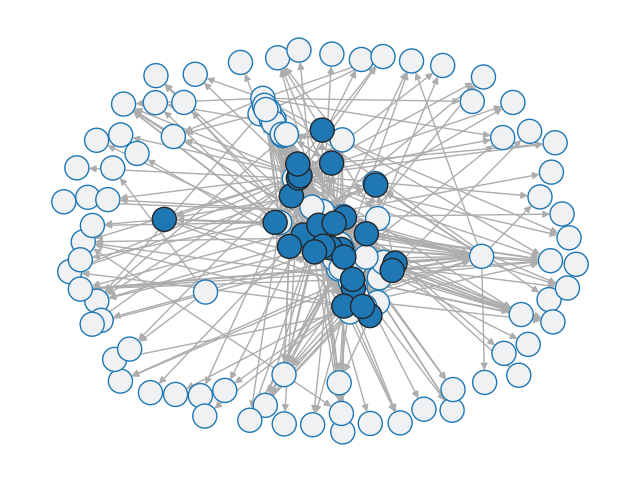

In [55]:
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()
ax, pos = cpnet.draw(G_coal, groups, coreness, ax)

# New graph with total flow in USD 

In [58]:
df_total = df.groupby(['Exporter','Importer'])['Value (thousands USD)'].sum().reset_index()
df_total

,Exporter,Importer,Value (thousands USD)
0,ABW,KOR,7.491343e+04
1,AGO,BEL,2.296520e+02
2,AGO,BRA,3.059060e+04
3,AGO,CHL,6.786450e+04
4,AGO,CHN,1.260183e+07
...,...,...,...
1932,ZWE,MWI,3.417301e+03
1933,ZWE,NAM,5.086895e+03
1934,ZWE,SWZ,8.320575e+03
1935,ZWE,ZAF,9.598700e+03
